# Setup

The data consists of the daily meteorological measurements taken at Madrid Barajas Airport for 19 years, from Jan 1 1997 to Dec 31 2015 ([Kaggle source](https://www.kaggle.com/juliansimon/weather_madrid_lemd_1997_2015.csv)).


The objective is to identify the best ML framework that minimizes the mean absolute error of predictions, using both univariate (purely autorgressive) and multivariate models. 

In this notebook, we explore the correlation between different forecasts (e.g. SARIMA and RNNs) and the accuracy of ensemble models.

### Imports

In [1116]:
import pandas as pd
import numpy as np

import math
from scipy import stats

import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore')

In [1117]:
# must install statsmodels v0.12 or higher to run statsmodels.tsa.arima.model
# !pip install git+https://github.com/statsmodels/statsmodels

In [1118]:
import statsmodels
statsmodels.__version__

'0.13.0.dev0+2.g54f7c05be'

In [1119]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler

In [1120]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

In [1121]:
from xgboost import XGBRegressor

In [1122]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DLA/Madrid_weather/'


Mounted at /content/drive


In [1123]:
SEED=2020
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load, preprocess

In [1124]:
df = pd.read_csv(path+'data/weather_madrid_LEMD_1997_2015.csv')
print(df.shape)
df.sample(5).T

(6812, 23)


,1331,2845,6512,1308,5153
CET,2000-11-29,2005-2-20,2015-3-7,2000-11-6,2011-6-17
Max TemperatureC,14,11,23,15,31
Mean TemperatureC,11,6,11,11,22
Min TemperatureC,8,2,-1,8,14
Dew PointC,9,-2,1,13,11
MeanDew PointC,8,-3,-3,4,8
Min DewpointC,5,-6,-7,-1,5
Max Humidity,94,70,80,94,77
Mean Humidity,82,51,45,65,40
Min Humidity,58,30,7,41,19


In [1125]:
rename_dict =  {'CET'                           :'date',
                'Max TemperatureC'              :'temperature_max',
                'Mean TemperatureC'             :'temperature',
                'Min TemperatureC'              :'temperature_min',
                'Dew PointC'                    :'dewpoint_max',
                'MeanDew PointC'                :'dewpoint',
                'Min DewpointC'                 :'dewpoint_min',
                'Max Humidity'                  :'humidity_max',
                ' Mean Humidity'                :'humidity',
                ' Min Humidity'                 :'humidity_min',
                ' Max Sea Level PressurehPa'    :'pressure_max',
                ' Mean Sea Level PressurehPa'   :'pressure',
                ' Min Sea Level PressurehPa'    :'pressure_min',
                ' Max VisibilityKm'             :'visibility_max',
                ' Mean VisibilityKm'            :'visibility',
                ' Min VisibilitykM'             :'visibility_min',
                ' Max Wind SpeedKm/h'           :'windspeed_max',
                ' Mean Wind SpeedKm/h'          :'windspeed',
                ' Max Gust SpeedKm/h'           :'gustspeed',      
                'Precipitationmm'               :'precipitation',
                ' CloudCover'                   :'cloudcover',
                ' Events'                       :'events',
                'WindDirDegrees'                :'winddirection',
                }

df.rename(columns=rename_dict, inplace=True)
df.sample(5).T

,6622,173,1535,5736,5734
date,2015-6-25,1997-6-23,2001-6-21,2013-1-20,2013-1-18
temperature_max,33,28,37,9,13
temperature,24,19,26,6,11
temperature_min,16,11,15,3,8
dewpoint_max,14,10,5,6,11
dewpoint,9,8,2,1,9
dewpoint_min,2,5,-3,-2,6
humidity_max,77,67,48,100,94
humidity,37,46,24,69,86
humidity_min,9,32,9,42,71


In [1126]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_max,6810.0,21.039648,8.867187,0.0,13.0,20.0,29.00,41.0
temperature,6809.0,14.658687,7.580461,-3.0,8.0,14.0,21.00,32.0
temperature_min,6810.0,8.640529,6.837626,-10.0,3.0,9.0,14.00,28.0
dewpoint_max,6810.0,8.120705,4.741067,-12.0,5.0,8.0,12.00,20.0
dewpoint,6810.0,4.976211,4.654270,-15.0,2.0,6.0,8.00,16.0
dewpoint_min,6810.0,1.451248,4.909705,-22.0,-2.0,2.0,5.00,14.0
humidity_max,6810.0,81.139354,17.531839,16.0,68.0,87.0,94.00,100.0
humidity,6810.0,57.971366,19.675744,15.0,41.0,59.0,74.00,100.0
humidity_min,6810.0,34.729369,19.320359,4.0,19.0,32.0,47.75,100.0
pressure_max,6812.0,1020.529360,6.235941,994.0,1017.0,1020.0,1024.00,1047.0


Process dates

In [ ]:
# convert string to datetime
df.date = df.date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

# 127 dates are missing, most of them in 2000 but also some in January 2004:  
existing_dates = list(df.date) 
for i in range(6939):
    d = df.date.iloc[0] + np.timedelta64(i, 'D')
    if not d in existing_dates:
        print(d)


In [1128]:
# Contiguous data starts from Feb 1, 2004, truncate the dataset accordingly:
df = df[2460:]
df.head()


,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection
2460,2004-02-01,12.0,9.0,7.0,9.0,8.0,6.0,100.0,92.0,82.0,1031,1030,1028,10.0,5.0,0.0,11,6,NaN,0.0,7.0,Fog,347
2461,2004-02-02,15.0,11.0,7.0,9.0,7.0,6.0,93.0,85.0,63.0,1033,1031,1030,10.0,10.0,8.0,10,5,NaN,0.0,5.0,NaN,353
2462,2004-02-03,17.0,10.0,3.0,8.0,5.0,2.0,100.0,79.0,48.0,1035,1033,1032,10.0,9.0,8.0,10,3,NaN,0.0,0.0,Fog,351
2463,2004-02-04,19.0,11.0,3.0,8.0,6.0,2.0,100.0,78.0,46.0,1037,1035,1034,9.0,9.0,9.0,10,3,23.0,0.0,0.0,NaN,359
2464,2004-02-05,19.0,11.0,3.0,8.0,5.0,2.0,100.0,76.0,40.0,1036,1035,1033,10.0,9.0,9.0,6,3,NaN,0.0,0.0,NaN,359


### Impute missing

In [1129]:
df.isna().sum()

date                  0
temperature_max       0
temperature           0
temperature_min       0
dewpoint_max          0
dewpoint              0
dewpoint_min          0
humidity_max          0
humidity              0
humidity_min          0
pressure_max          0
pressure              0
pressure_min          0
visibility_max      630
visibility          630
visibility_min      630
windspeed_max         0
windspeed             0
gustspeed          1400
precipitation         0
cloudcover         1050
events             3229
winddirection         0
dtype: int64

In [1130]:
df[df.visibility.isna()].sample(2)

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection
4890,2010-09-27,23.0,16.0,8.0,5.0,3.0,1.0,76.0,45.0,23.0,1015,1014,1012,NaN,NaN,NaN,11,5,NaN,0.0,NaN,NaN,65
2938,2005-05-24,30.0,20.0,10.0,8.0,2.0,-3.0,58.0,32.0,12.0,1024,1022,1019,NaN,NaN,NaN,14,8,34.0,0.0,NaN,NaN,114


In [1131]:
df.visibility.value_counts().sort_index()

1.0        2
2.0        5
3.0        8
4.0       24
5.0       41
6.0       48
7.0       76
8.0      139
9.0      284
10.0    1849
11.0      93
12.0     112
13.0      80
14.0      74
15.0      65
16.0      60
17.0      76
18.0      46
19.0      52
20.0      44
21.0      46
22.0      46
23.0      31
24.0      37
25.0      16
26.0      30
27.0      28
28.0      33
29.0      40
30.0      93
31.0     144
Name: visibility, dtype: int64

In [1132]:
# impute missing visibility with the Mode of visibility=10 (about 50% )
for col in df.columns[13:16]:
    df[col].fillna(10, inplace=True)

In [1133]:
# gustspeed, cloudcover -- remove the features b/c:
#    - missing values do not appear to follow any pattern 
#    - these features seem secondary in the context of at least 1-day ahead prediction
df.drop(['gustspeed','cloudcover'], axis=1, inplace=True)

In [1134]:
# Events: categories too granular, likely to introduce noise
df.events.value_counts(dropna=False).sort_index()

Fog                        131
Fog-Rain                    41
Fog-Rain-Snow                1
Fog-Snow                     4
Rain                       733
Rain-Hail                    1
Rain-Hail-Thunderstorm       5
Rain-Snow                   27
Rain-Snow-Thunderstorm       1
Rain-Thunderstorm          150
Snow                         8
Thunderstorm                21
NaN                       3229
Name: events, dtype: int64

In [1135]:
# Leave just 1 large category -  Rain with all its variants (~90% of non-empty events)
# Replace Rain:1, everything else: 0
df.events = [1 if 'Rain' in str(event) else 0 for event in df.events]
df.rename(columns={'events':'rain'}, inplace=True)

In [1136]:
df.isna().sum()

date               0
temperature_max    0
temperature        0
temperature_min    0
dewpoint_max       0
dewpoint           0
dewpoint_min       0
humidity_max       0
humidity           0
humidity_min       0
pressure_max       0
pressure           0
pressure_min       0
visibility_max     0
visibility         0
visibility_min     0
windspeed_max      0
windspeed          0
precipitation      0
rain               0
winddirection      0
dtype: int64

### EDA

In [1137]:
# helper plot function
def plot_series(series_dict, start=0, t=df.date):
    """Args: 
         t, array-like of timesteps (x axis)
         series_dist, dict of {'series_name': series}
         view, optional tuple or list of (t_start, t_end)         
    """
    plt.figure(figsize=(16,6))
    for label, series in series_dict.items():
        plt.plot(t[start:], series[start:], label=label)
    plt.legend()
    plt.show()

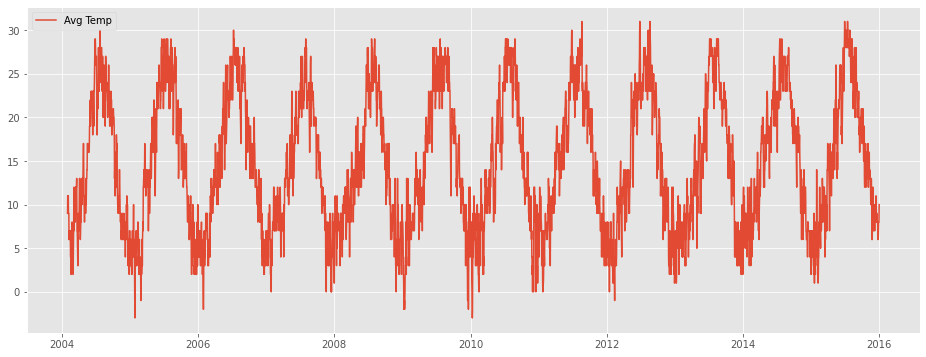

In [1138]:
plot_series({'Avg Temp': df.temperature})

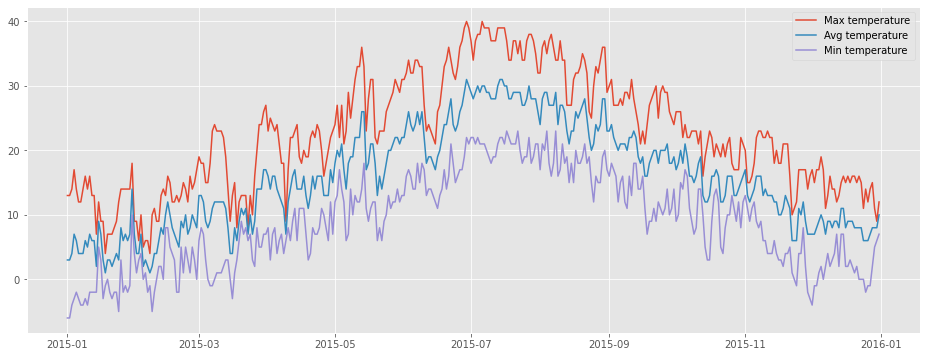

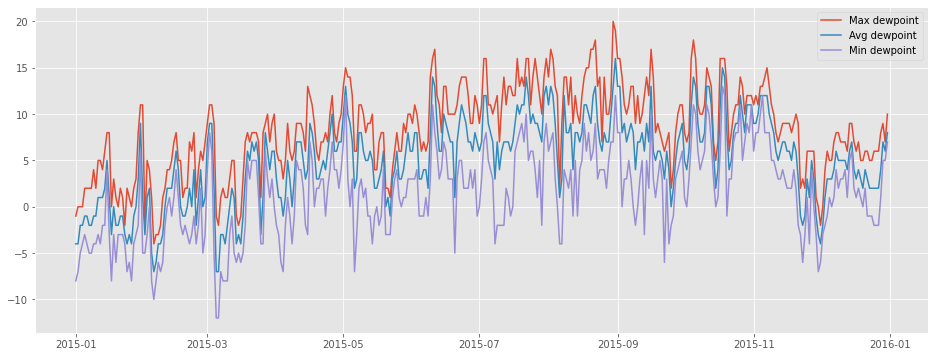

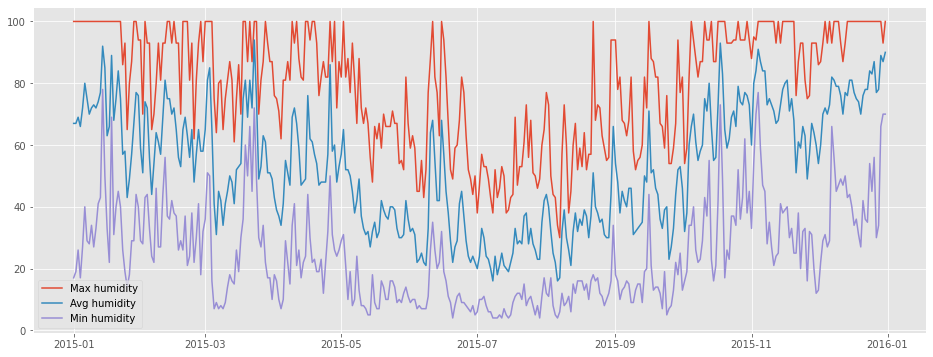

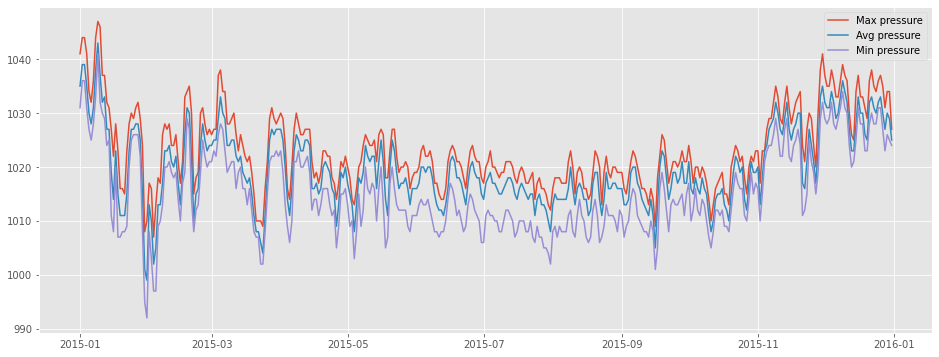

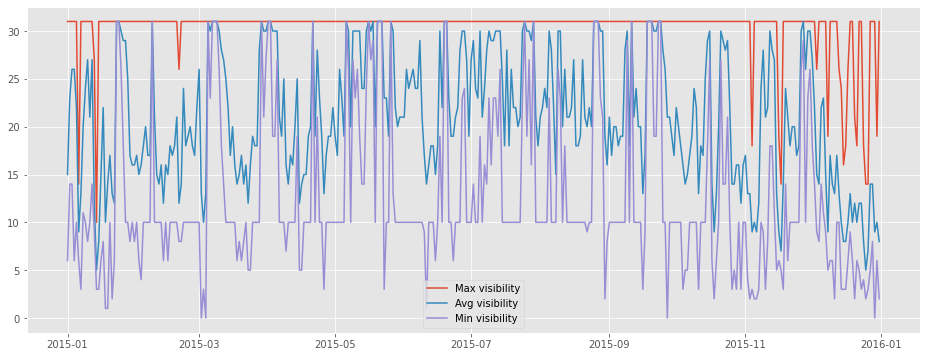

In [1139]:
for f in ['temperature','dewpoint','humidity','pressure','visibility']:
    plot_series({f'Max {f}': df[f'{f}_max'], 
                 f'Avg {f}': df[f], 
                 f'Min {f}': df[f'{f}_min']}, 
                -365)

In [1140]:
# remove min and max, they would introduce collinearity, especially given little data (only 4,352 data points)
# keep only averages
for f in ['temperature','dewpoint','humidity','pressure','visibility']:
    df.drop([f'{f}_max', f'{f}_min'], axis=1, inplace=True)

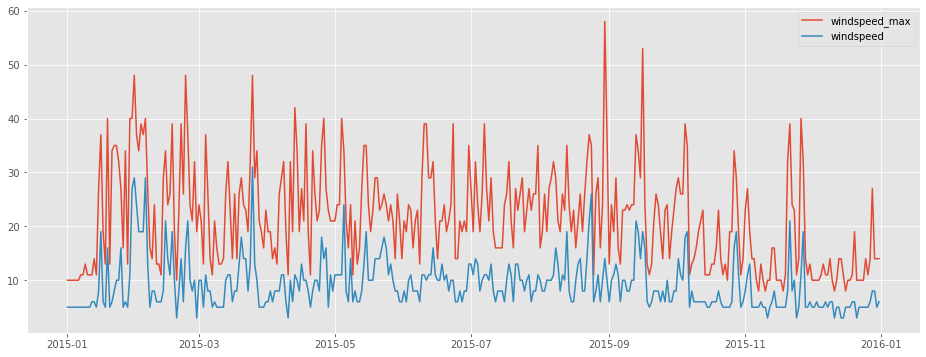

In [1141]:
# same for wind speed - remove max:
plot_series({'windspeed_max': df.windspeed_max, 'windspeed': df.windspeed}, -365)

In [1142]:
df.drop('windspeed_max', axis=1, inplace=True)

In [1143]:
df.head()

,date,temperature,dewpoint,humidity,pressure,visibility,windspeed,precipitation,rain,winddirection
2460,2004-02-01,9.0,8.0,92.0,1030,5.0,6,0.0,0,347
2461,2004-02-02,11.0,7.0,85.0,1031,10.0,5,0.0,0,353
2462,2004-02-03,10.0,5.0,79.0,1033,9.0,3,0.0,0,351
2463,2004-02-04,11.0,6.0,78.0,1035,9.0,3,0.0,0,359
2464,2004-02-05,11.0,5.0,76.0,1035,9.0,3,0.0,0,359


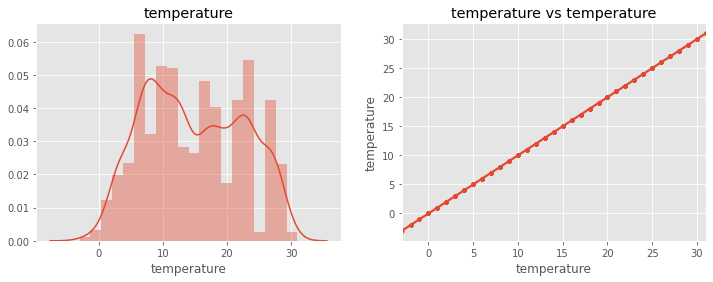

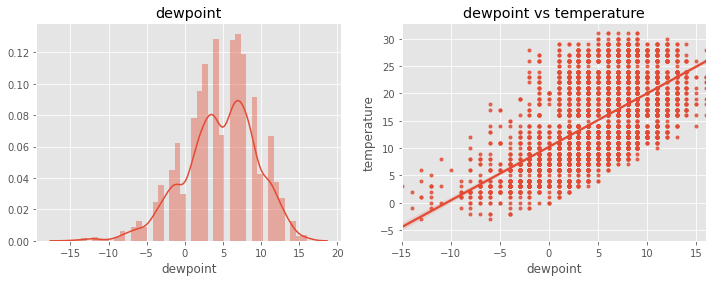

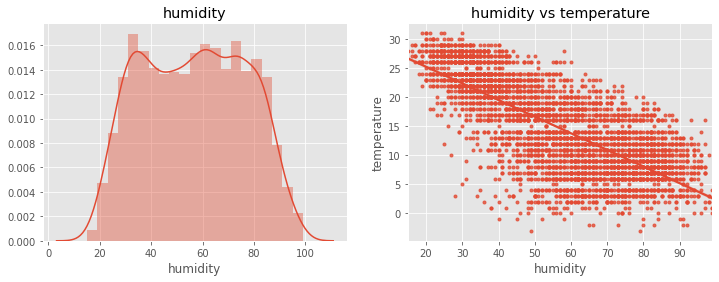

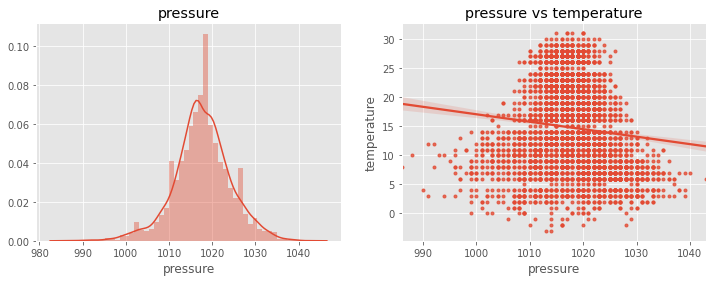

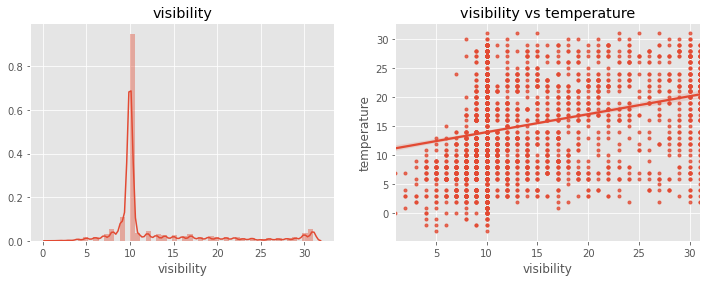

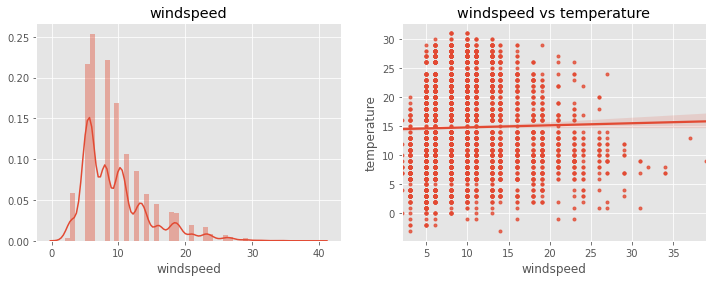

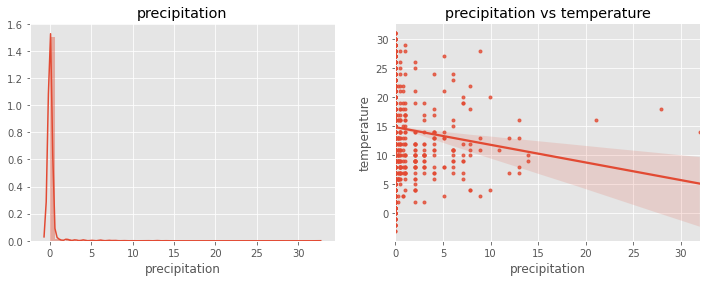

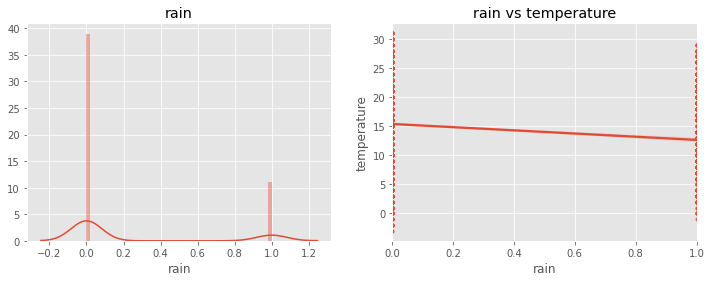

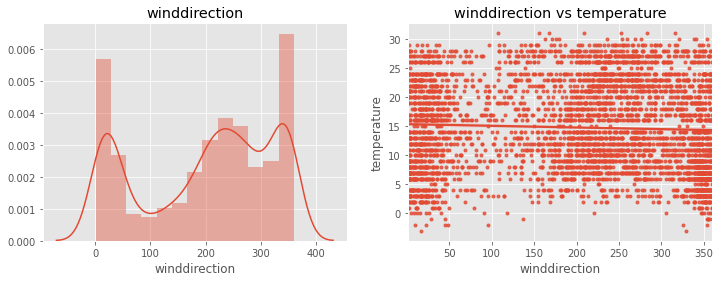

In [1144]:
def plot_feature(f):
    _, (ax0,ax1) = plt.subplots(1, 2, figsize=(12, 4))
    sns.distplot(df[f], ax=ax0)
    ax0.set_title(f)
    sns.regplot(y='temperature', x=f, data=df, ax=ax1, marker='.')
    ax1.set_title(f'{f} vs temperature')
    plt.show()

for f in df.columns[1:]:
    plot_feature(f)

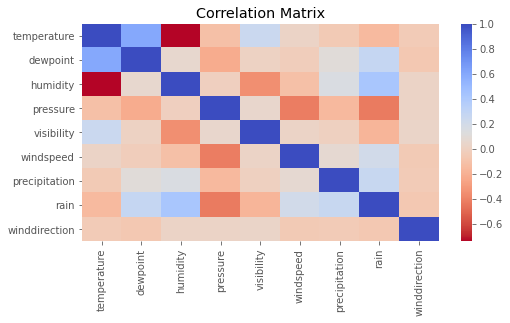

In [1145]:
plt.figure(figsize=(8,4))
sns.heatmap(df.drop('date', axis=1).corr(), cmap='coolwarm_r')
plt.title('Correlation Matrix')
plt.show()

### Workflow

The general workflow:
1. Select a single target (e.g. temperature). Do not optimize a whole vector. 
2. Decide on the metric: MAE(y_true,y_hat), but not MAPE b/c 0 degrees
3. Copy the target variable into a separate tensor Y 
4. Predictors X include the target Y.  Remove the date from X
5. Split the timeline into non-overlapping consecutive train and test. E.g. test the last 365 days of data (year 2015)
6. Leakage control: distort the last observation
7. Fit and predict 1 Horizon ahead, for both univariate and multivariate models:
    - SARIMA
    - RNNs
8. Explore residuals correlations, build ensemble models







In [1146]:
TARGET = 'temperature'

TEST_PERIOD = -3*365   # last days of the target

HORIZON = 1  # forecast horizon (e.g. for 1-day ahead forecasts, horizon=1)

PERIOD = 365  # differencing period for SARIMA

VIEW_PERIOD = 100 # the last n days to visualzie y_true, y_hat

y_hats = []  # accumulate the forecasts


In [1147]:
# Univariate data
y = df[TARGET].values.copy()
y_true  = y[TEST_PERIOD:].copy()
y_train = y[:TEST_PERIOD].copy()

t_train = df.date[:TEST_PERIOD]


In [1148]:
# Multivariate data
exog_cols = list(df.columns)
exog_cols.remove('date')
TARGET_INDEX = exog_cols.index(TARGET)

exog_data = df[exog_cols].values.copy()

normalize = False
if normalize:
    scaler = StandardScaler()
    exog_data = scaler.fit_transform(exog_data)


In [1149]:
reports = pd.DataFrame(columns=['target', 'var', 'horizon', 'forecast', 'MAE'])
reports

,target,var,horizon,forecast,MAE


**Leakage control**

In a leakage-proof model, the last observation cannot influence the last prediction. 
- distort the last actual observation, e.g increase the target y[-1] by x1000000
- for each model, check that y_hat[-1] is not affected and is within reasonable range

In [1150]:
y[-1]         *= 1_000_000
exog_data[-1] *= 1_000_000

print(exog_data[-1])
print(y[-1])
print(y_true[-1])

[1.000e+07 8.000e+06 9.000e+07 1.025e+09 8.000e+06 6.000e+06 2.500e+05
 1.000e+06 3.130e+08]
10000000.0
10.0


# Benchmarks

**1. Naive**

The basic benchmark is the naive forecast S(t)=S(t-1)

In [1151]:
def naive_forecast(series, test_period=TEST_PERIOD, horizon=HORIZON):
    return series[test_period-horizon : -horizon]

y_hat = naive_forecast(y)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6., 7., 8., 8., 8.])

In [1152]:
reports.loc[len(reports)] = [TARGET, 'uni', HORIZON, 'Naive S(t)=S(t-1)', MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584


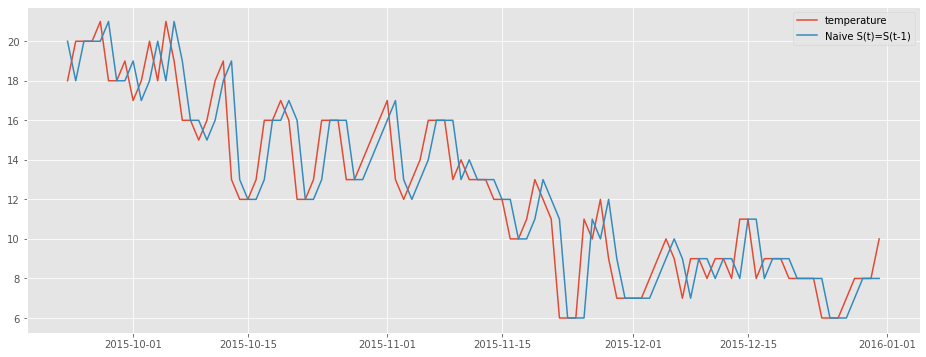

In [1153]:
plot_series({f'{TARGET}': y_true,  'Naive S(t)=S(t-1)': y_hat}, -VIEW_PERIOD)

In [1154]:
# check naive forecast error for n-day ahead horizons
for h in range(1,11):
    print(h, MAE(y_true, naive_forecast(y, horizon=h)))    

1 1.4885844748858448
2 2.0547945205479454
3 2.4575342465753423
4 2.649315068493151
5 2.7470319634703197
6 2.8529680365296803
7 2.9013698630136986
8 2.9488584474885844
9 3.0191780821917806
10 3.135159817351598


**2. Moving average differenced**

A slightly less naive approach, applicable only for periodic series, relies on smoothing the signal as compared to previous periods:  
S(t) = MA[S(t-1)-S(t-1-period)] + S(t-period)

In [1155]:
def ma_trailing(series, window):
    """ Produce a trailing moving average over a fixed period length (window)
        The trailing MA does NOT include the last observation to prevent leakage
    """
    series, window = np.array(series), int(window)
    return np.array([np.nanmean(series[t-window:t]) for t in range(window, len(series))])

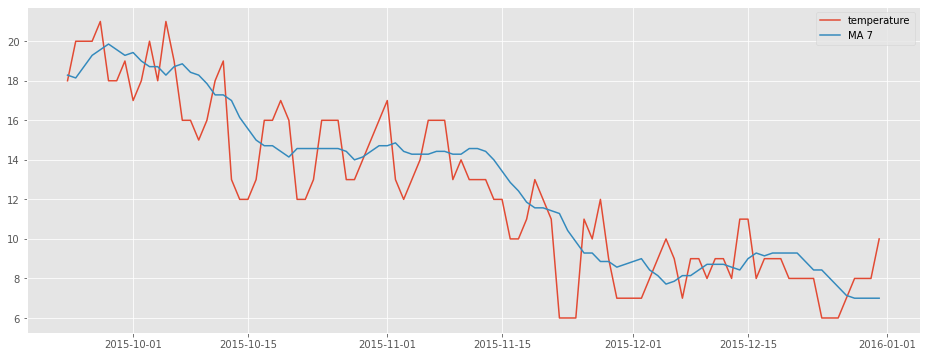

In [1224]:
window = 7 #e.g. weekly moving average
plot_series({f'{TARGET}': y_true, f'MA {window}': ma_trailing(y, window)}, -VIEW_PERIOD)

In [1157]:
def diff_forecast(series, ma_window, period=PERIOD, split_time=TEST_PERIOD):
    """ Implements period-based  differencing: 
        S_hat(t) =  S(t-period) +  MA_ma_window [S(t)-S(t-period)]  <-- no leakage from S(t)!
        NB: works well only for strictly periodic series such as 24 hours or 365 days
    """
    diff_series = (series[period:]-series[:-period]) # S(t)-S(t-period)
    return series[split_time-period:-period] + ma_trailing(diff_series, ma_window)[split_time:]


In [1158]:
# the simplest MA diff forecast is window=1: S(t) = S(t-1) - S(t-1-period) + S(t-period)
y_hat = diff_forecast(y, ma_window=1)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([ 4., 10.,  6.,  6.,  7.])

In [1159]:
reports.loc[len(reports)] = [TARGET, 'uni', HORIZON, 'MA differenced', MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772


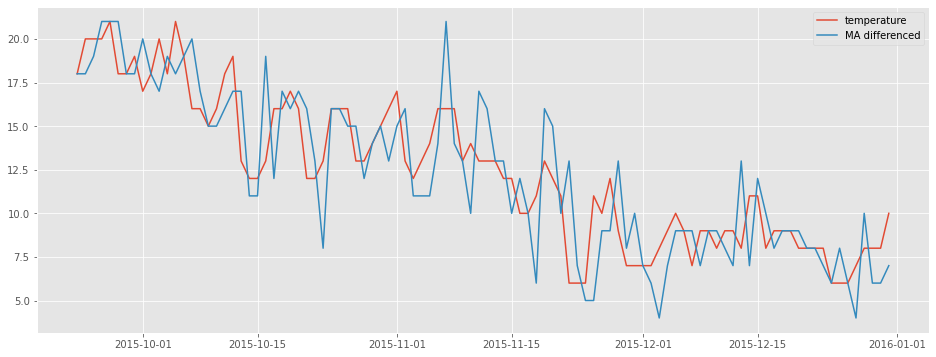

In [1160]:
plot_series({f'{TARGET}': y_true,  'MA differenced': y_hat}, -VIEW_PERIOD)

In [1161]:
# check MA differenced forecast error for different MA windows
for w in range(1,10):
    print(w, MAE(y_true, diff_forecast(y, w)))    

1 2.149771689497717
2 2.367579908675799
3 2.533637747336378
4 2.624200913242009
5 2.708675799086758
6 2.7899543378995433
7 2.8331376386170906
8 2.8746575342465754
9 2.906950786402841


Conclusion: naive forecast is more accurate than differenced

# SARIMA

### Autocorrelations

At least 1 differencing is necessary to make the temperature series stationary:
- 365-day period i.e. D=1 in SARIMA
- potentially, extra differencing to eliminate secular trends if any i.e. d=0 or 1 -- optimize through grid search

In [1162]:
def differenced(series, period):
    return series[period:] - series[:-period]

In [1163]:
D_y = differenced(y, PERIOD)
print(D_y.shape)

D_train = differenced(y_train, PERIOD)
print(D_train.shape)

(3987,)
(2892,)


In [1164]:
# Basic regression slope
# The trend is significant (~0.12 C/year) -- de-trend with d=1 differencing
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.arange(len(y_train)).reshape(-1, 1), y_train)
print(365*reg.coef_)

[0.10009277]


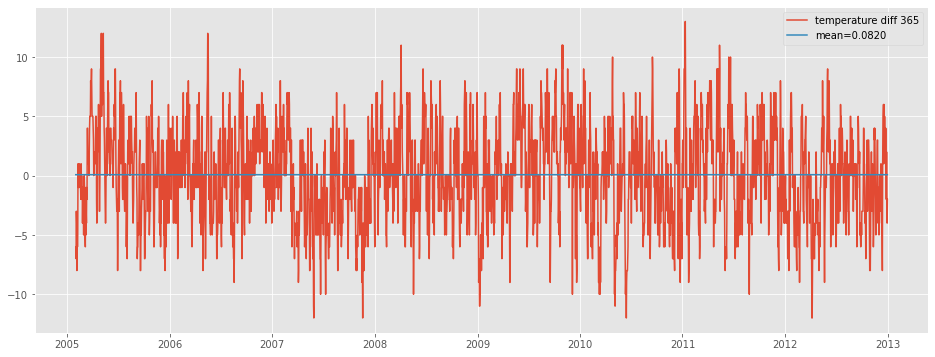

In [1165]:
plot_series({f'{TARGET} diff {PERIOD}': D_train, 
             f'mean={np.nanmean(D_train):.4f}': np.full(len(D_train), np.nanmean(D_train))}, 
            t=t_train[PERIOD:])

In [1166]:
# the distribution of differences is platykurtic -- not white noise, this is good news
print(np.nanmean(D_train))
print(np.nanstd(D_train))
print(stats.skew(D_train))
print(stats.kurtosis(D_train))

0.08195020746887967
4.010514267408063
-0.00636004597550615
-0.25618820707932155


In [1167]:
def plot_normal_qq(arr, title):
    _, (ax0,ax1) = plt.subplots(1, 2, figsize=(16, 5))
    lim = max(np.abs(arr))
    limrange =  np.arange(-lim,lim,lim/1000)
    sns.distplot(arr, bins=25, color='k', kde=False, norm_hist=True, ax=ax0, label='Actual')
    ax0.plot(limrange, stats.norm.pdf(limrange, np.nanmean(arr), np.nanstd(arr)), 'r', lw=1, label='Normal')
    ax0.set_title(f'{title}:  mean={np.nanmean(arr):.2f}  std={np.nanstd(arr):.2f}')
    ax0.set_xlim(-lim,lim)
    ax0.legend()
    qqplot(arr, line='q', fit=True, color='k', marker='.', ax=ax1)
    ax1.set_title(f'{title}: Q-Q plot')
    plt.show()   

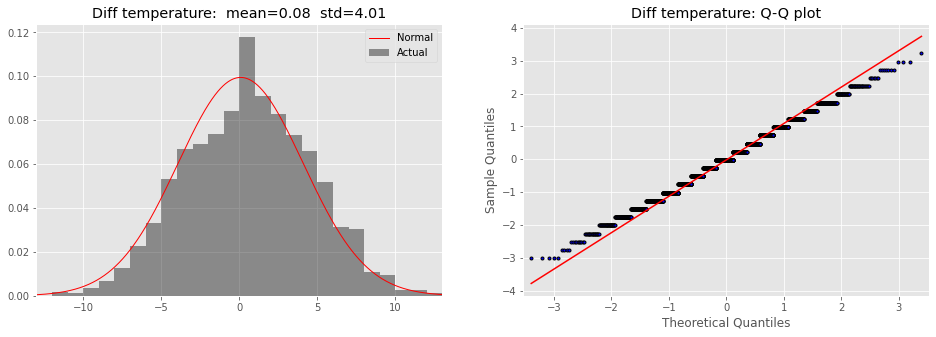

In [1168]:
plot_normal_qq(D_train, title=f'Diff {TARGET}')

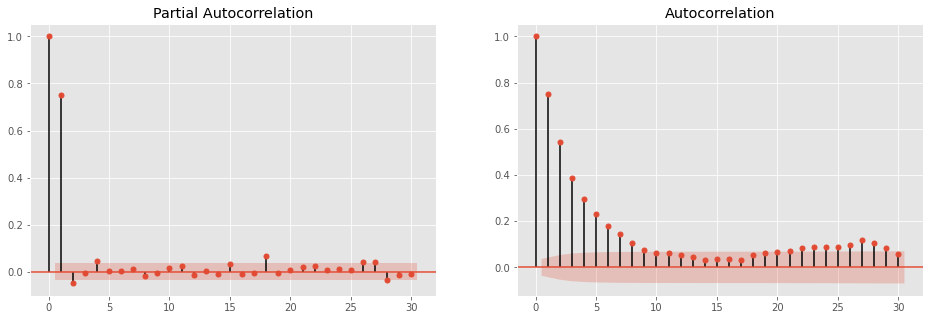

In [1169]:
# PACF plot indicates an AR(1) process
_, (ax0,ax1) = plt.subplots(1, 2, figsize=(16, 5))
plot_pacf(D_train, lags=30, ax=ax0)
plot_acf (D_train, lags=30, ax=ax1)
plt.show()

### Univariate

In [1170]:
# SARIMA basic (p,d,q)(P,D,Q,s) assumption:
# (P,D,Q) = (0,1,0,365) -- already differenced with period 365
# (p,d,q) = (1,?,?) -- p,d,q grid search

In [1171]:
D_y[-5:]

array([3.000000e+00, 1.000000e+00, 3.000000e+00, 5.000000e+00,
       9.999998e+06])

In [1172]:
def sarima(diff_series, order, series=y):
    
    model = ARIMA(diff_series[:TEST_PERIOD], order=order)
    results = model.fit()    
    
    extended_results = results.extend(endog=diff_series[TEST_PERIOD:])    
    D_forecast = extended_results.forecasts[0]

    y_hat = D_forecast + y[TEST_PERIOD-PERIOD:-PERIOD]

    return y_hat

The simplest AR(1) works better than any other order:

In [1173]:
# ARIMA: grid search of (p,d,q)
orders=[(1,0,0),
        (1,1,0),
        (1,0,1),
        (1,1,1),
        (2,0,0),              
        (2,1,0),
        (2,0,1),
        (2,1,1),
       ]

In [1174]:
mae_scores = []
for order in orders:
    y_hat = sarima(D_y, order=order)
    mae = MAE(y_true, y_hat)
    mae_scores.append(mae)
    print(f'{mae:.4f}')

2.0748
2.1634
2.0763
2.0791
2.0765
2.1596
2.0765
2.0862


In [1175]:
best_order = orders[mae_scores.index(min(mae_scores))]
best_order

(1, 0, 0)

In [1176]:
y_hat = sarima(D_y, order=best_order)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([4.01825837, 9.26952225, 5.76867966, 5.26952225, 5.77036484])

In [1177]:
reports.loc[len(reports)] = [TARGET, 'uni', HORIZON, f'SARIMA {best_order}(0, 1, 0, 365)', 
                             MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772
2,temperature,uni,1,"SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074753


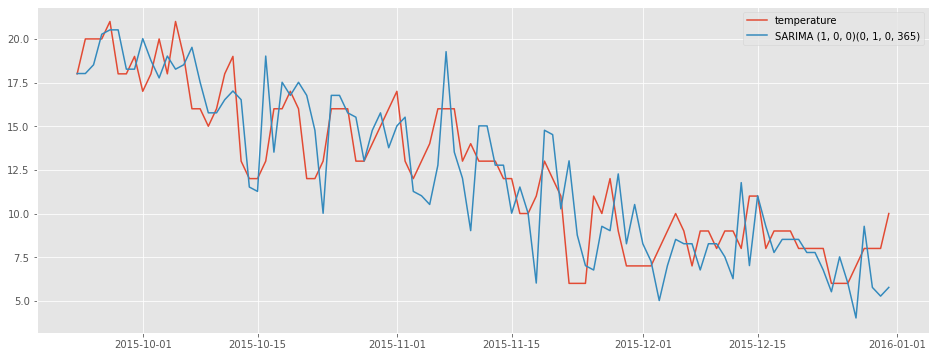

In [1178]:
plot_series({f'{TARGET}': y_true, f'SARIMA {best_order}(0, 1, 0, 365)': y_hat}, -VIEW_PERIOD)

Verify if incremental retraining on S[:-t] adds forecast accuracy for S[t+1]

In [1179]:
def sarima_incremental(diff_series, order, series=y):
    tic = time.time()
    y_hat=np.zeros(-TEST_PERIOD)
    
    for t in range(TEST_PERIOD,0):
        model = ARIMA(diff_series[:t], order=order)
        results = model.fit()
        D_forecast = results.forecast(steps=1)[0]

        y_hat[t-TEST_PERIOD]  = D_forecast + series[t-PERIOD]

        toc = time.time()
        print(f'\r {t} in {toc-tic:.1f} sec', end='')
    return y_hat

In [1180]:
y_hat = sarima_incremental(D_y, order=best_order)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

 -1 in 245.3 sec

array([4.04096572, 9.29216495, 5.79238103, 5.29231429, 5.79405502])

In [1181]:
reports.loc[len(reports)] = [TARGET, 'uni', HORIZON, f'Incremental SARIMA {best_order}(0, 1, 0, 365)', 
                             MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772
2,temperature,uni,1,"SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074753
3,temperature,uni,1,"Incremental SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074502


Conclusion: Incremental retraining every day during the TEST_PERIOD does NOT add accuracy. Apparently, the model trained on 2004-2014 already extracted any linear patterns present in the data.

### Multivariate

In [1182]:
def sarima_x(diff_series, order, series=y):
    
    model = ARIMA(diff_series[:TEST_PERIOD], order=order, exog=exog_data[PERIOD-1:TEST_PERIOD-1])
    results = model.fit()    
    
    extended_results = results.extend(endog=diff_series[TEST_PERIOD:], exog=exog_data[TEST_PERIOD-1:-1])
    D_forecast = extended_results.forecasts[0]

    y_hat = D_forecast + y[TEST_PERIOD-PERIOD:-PERIOD]

    return y_hat

In [1183]:
mae_scores = []
for order in orders:
    y_hat = sarima_x(D_y, order=order)
    mae = MAE(y_true, y_hat)
    mae_scores.append(mae)
    print(f'{mae:.4f}')

2.0376
2.1263
2.0287
2.1411
2.0299
2.1141
2.0293
2.0702


In [1184]:
best_order_x = orders[mae_scores.index(min(mae_scores))]
best_order_x

(1, 0, 1)

In [1185]:
y_hat = sarima_x(D_y, order=best_order_x)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([4.62775812, 9.29882869, 5.8507042 , 6.30226195, 6.43836901])

In [1186]:
reports.loc[len(reports)] = [TARGET, 'multi', HORIZON, f'Multivariate SARIMAX {best_order_x}(0, 1, 0, 365)', 
                             MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772
2,temperature,uni,1,"SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074753
3,temperature,uni,1,"Incremental SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074502
4,temperature,multi,1,"Multivariate SARIMAX (1, 0, 1)(0, 1, 0, 365)",2.028708


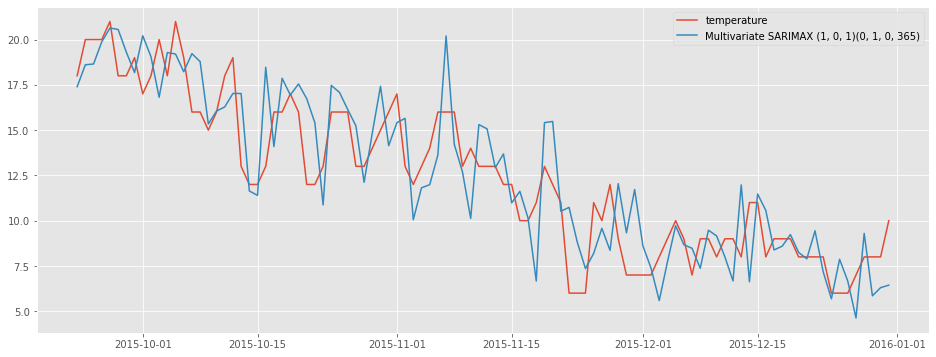

In [1187]:
plot_series({f'{TARGET}': y_true, f'Multivariate SARIMAX {best_order_x}(0, 1, 0, 365)': y_hat}, -VIEW_PERIOD)

Multivariate SARIMAX observations:
- exogenous regressors improve accuracy
- unlike in univariate SARIMA, higher order (2,1,1) works better
- the best SARIMAX is still worse than the naive forecast

# LSTM

### Univariate

In [1188]:
WINDOW_SIZE = 60
BATCH_SIZE  = 16
SPLIT_DS = 0.9

EPOCHS = 50
SHUFFLE_BUFFER = 1024
VERBOSE = 0

In [1189]:
def rnn_dataset(series,
                target_index=0, 
                window_size=WINDOW_SIZE, 
                batch_size=BATCH_SIZE, 
                shuffle_buffer=SHUFFLE_BUFFER,
                split=SPLIT_DS,
                ):
    """Produces windowed datasets from series
       each dataset element of (X,Y) is (batch_size, window_size, features),(batch_size, window_size)
       the features dimension equals 1 for univariate series, or series.shape[1] for multivariate series
    """

    # For univariate series, add feature dimension required by TF RNNs
    if series.ndim==1: series = series[..., np.newaxis]
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)

    split = int(split*series.shape[0])
    train_ds = dataset.take(split).map(lambda w: (w[:-1], w[1:,target_index])).batch(batch_size)
    val_ds   = dataset.skip(split).map(lambda w: (w[:-1], w[1:,target_index])).batch(batch_size)

    return train_ds, val_ds

def rnn_forecast(model, 
                 series, 
                 window_size=WINDOW_SIZE, 
                 batch_size=BATCH_SIZE, 
                 ):
    
    if series.ndim==1: series = series[..., np.newaxis]

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size)
    
    return model.predict(dataset)    

def scheduler(epoch, lr):
    # keep the original lr for flat_period epochs, exponential decay since then subject to floor_lr
    flat_period, decay, floor_lr = 5, -0.1, 1e-4
    if epoch<=flat_period: 
        return lr
    return max(lr*np.exp(decay), floor_lr)
   
lr_callback=callbacks.LearningRateScheduler(scheduler, verbose=VERBOSE) 
es_callback=callbacks.EarlyStopping(monitor='val_mae', verbose=VERBOSE, patience=4, mode='min')

def plot_training(history, ylims):
    hist = history.history
    epochs = np.arange(1,1+len(hist['loss']))
    plt.figure(figsize=(10,4))
    plt.plot(epochs, hist['mae'], label='MAE train') 
    plt.plot(epochs, hist['val_mae'], label='MAE val') 
    plt.ylim(ylims)
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.show()

In [1190]:
train_ds, val_ds = rnn_dataset(y_train)
train_ds.element_spec

(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, None), dtype=tf.float64, name=None))

In [1191]:
model = Sequential([
    LSTM(32, input_shape=[None, 1], return_sequences=True),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(loss='mae',   
              optimizer=Adam(),
              metrics=['mae'])

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, None, 32)          4352      
_________________________________________________________________
dense_56 (Dense)             (None, None, 16)          528       
_________________________________________________________________
dense_57 (Dense)             (None, None, 1)           17        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [1192]:
tic = time.time()

history = model.fit(train_ds, 
                    epochs=EPOCHS,  
                    validation_data=val_ds,
                    callbacks=[lr_callback, es_callback],
                    verbose=1)

toc = time.time()
print(f'done in {toc-tic:.1f} sec')

Epoch 1/50
184/184 [==============================] - 2s 9ms/step - loss: 7.5592 - mae: 7.5592 - val_loss: 1.9269 - val_mae: 1.9269
Epoch 2/50
184/184 [==============================] - 1s 7ms/step - loss: 1.6708 - mae: 1.6708 - val_loss: 1.5802 - val_mae: 1.5802
Epoch 3/50
184/184 [==============================] - 1s 7ms/step - loss: 1.5505 - mae: 1.5505 - val_loss: 1.5379 - val_mae: 1.5379
Epoch 4/50
184/184 [==============================] - 1s 7ms/step - loss: 1.5187 - mae: 1.5187 - val_loss: 1.5289 - val_mae: 1.5289
Epoch 5/50
184/184 [==============================] - 1s 7ms/step - loss: 1.5080 - mae: 1.5080 - val_loss: 1.5041 - val_mae: 1.5041
Epoch 6/50
184/184 [==============================] - 1s 7ms/step - loss: 1.4997 - mae: 1.4997 - val_loss: 1.4864 - val_mae: 1.4864
Epoch 7/50
184/184 [==============================] - 1s 7ms/step - loss: 1.4933 - mae: 1.4933 - val_loss: 1.4952 - val_mae: 1.4952
Epoch 8/50
184/184 [==============================] - 1s 7ms/step - loss: 1.

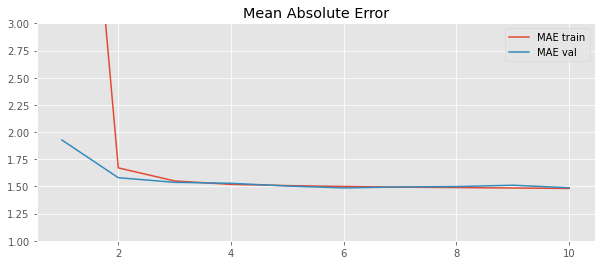

In [1193]:
plot_training(history, ylims=(1,3))

In [1194]:
y_hat = rnn_forecast(model, y[TEST_PERIOD-WINDOW_SIZE:-1])
y_hat = np.squeeze(y_hat[:, -1, -1])
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.099062 , 6.7867208, 7.603767 , 7.678076 , 7.699106 ],
      dtype=float32)

In [1195]:
reports.loc[len(reports)] = [TARGET, 'uni', HORIZON, 'LSTM-32 Dense-16', MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772
2,temperature,uni,1,"SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074753
3,temperature,uni,1,"Incremental SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074502
4,temperature,multi,1,"Multivariate SARIMAX (1, 0, 1)(0, 1, 0, 365)",2.028708
5,temperature,uni,1,LSTM-32 Dense-16,1.505956


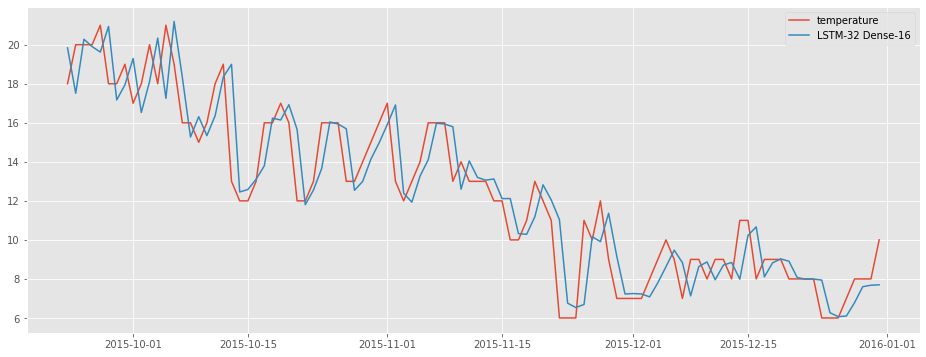

In [1196]:
plot_series({f'{TARGET}': y_true, 'LSTM-32 Dense-16': y_hat}, -VIEW_PERIOD)

The univariate RNN basically learns that the optimal forecast
 is naive.

### Multivariate

In [1197]:
train_ds, val_ds = rnn_dataset(exog_data[:TEST_PERIOD], target_index=TARGET_INDEX)
train_ds.element_spec

(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, None), dtype=tf.float64, name=None))

In [1198]:
model = Sequential([
    LSTM(512, input_shape=[None, exog_data.shape[1]], return_sequences=True),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(loss='mae',   
              optimizer=Adam(),
              metrics=['mae'])

model.summary()


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, None, 512)         1069056   
_________________________________________________________________
dense_58 (Dense)             (None, None, 16)          8208      
_________________________________________________________________
dense_59 (Dense)             (None, None, 1)           17        
Total params: 1,077,281
Trainable params: 1,077,281
Non-trainable params: 0
_________________________________________________________________


In [1199]:
tic = time.time()

history = model.fit(train_ds, 
                    epochs=EPOCHS,  
                    validation_data=val_ds,
                    callbacks=[lr_callback, es_callback],
                    verbose=VERBOSE)

toc = time.time()
print(f'done in {toc-tic:.1f} sec')

done in 50.3 sec


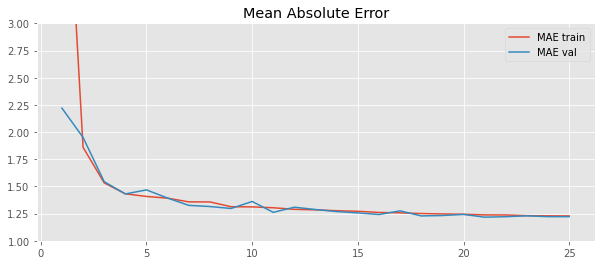

In [1200]:
plot_training(history, ylims=(1,3))

In [1201]:
y_hat = rnn_forecast(model, exog_data[TEST_PERIOD-WINDOW_SIZE:-1])
y_hat = np.squeeze(y_hat[:, -1, -1])
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.701906 , 6.4446125, 7.5198917, 8.280825 , 8.126377 ],
      dtype=float32)

In [1202]:
reports.loc[len(reports)] = [TARGET, 'multi', HORIZON, 'Multivariate LSTM-512 Dense-16', MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772
2,temperature,uni,1,"SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074753
3,temperature,uni,1,"Incremental SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074502
4,temperature,multi,1,"Multivariate SARIMAX (1, 0, 1)(0, 1, 0, 365)",2.028708
5,temperature,uni,1,LSTM-32 Dense-16,1.505956
6,temperature,multi,1,Multivariate LSTM-512 Dense-16,1.419175


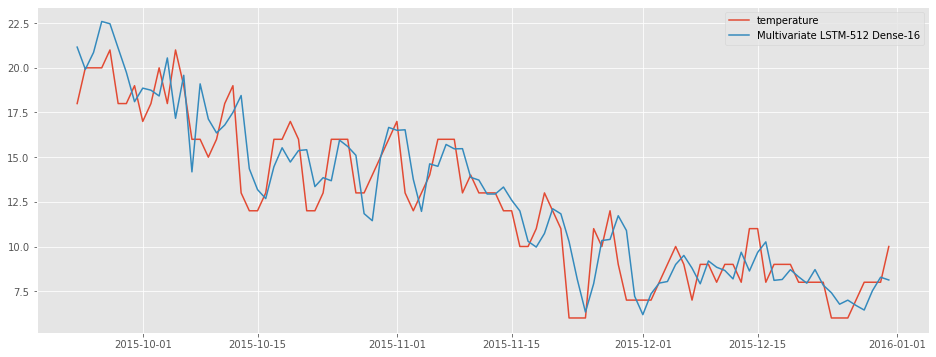

In [1203]:
plot_series({f'{TARGET}': y_true, 'Multivariate LSTM-512 Dense-16': y_hat}, -VIEW_PERIOD)

# XGBoost

### Multivariate

In [1204]:
def windowed_data(series,
                target_index=0, 
                window_size=WINDOW_SIZE, 
                split=SPLIT_DS,
                ):
    if series.ndim==1: series = series[..., np.newaxis]
    n_samples = len(series)-window_size   

    X = np.zeros((n_samples, window_size, series.shape[1]))
    Y = np.zeros(n_samples)

    for s in range(n_samples):
        Y[s]     = series[  s+window_size, target_index]
        X[s,...] = series[s:s+window_size, :]
    
    X = np.reshape(X, (n_samples,-1))

    return X,Y

In [1205]:
X_train,Y_train = windowed_data(exog_data[:TEST_PERIOD], target_index=TARGET_INDEX)
X_test, _ = windowed_data(exog_data[TEST_PERIOD-WINDOW_SIZE:], target_index=TARGET_INDEX)

In [1206]:
tic = time.time()
model = XGBRegressor(objective='reg:squarederror', reg_lambda=10, n_estimators=500)
model.fit(X_train,Y_train)
toc = time.time()
print(f'done in {toc-tic:.1f} sec')	

done in 16.4 sec


In [1207]:
y_hat = model.predict(X_test)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.2152686, 6.1041975, 6.2548475, 7.5332503, 8.233393 ],
      dtype=float32)

In [1208]:
reports.loc[len(reports)] = [TARGET, 'multi', HORIZON, 'XGBoost', MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772
2,temperature,uni,1,"SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074753
3,temperature,uni,1,"Incremental SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074502
4,temperature,multi,1,"Multivariate SARIMAX (1, 0, 1)(0, 1, 0, 365)",2.028708
5,temperature,uni,1,LSTM-32 Dense-16,1.505956
6,temperature,multi,1,Multivariate LSTM-512 Dense-16,1.419175
7,temperature,multi,1,XGBoost,1.431866


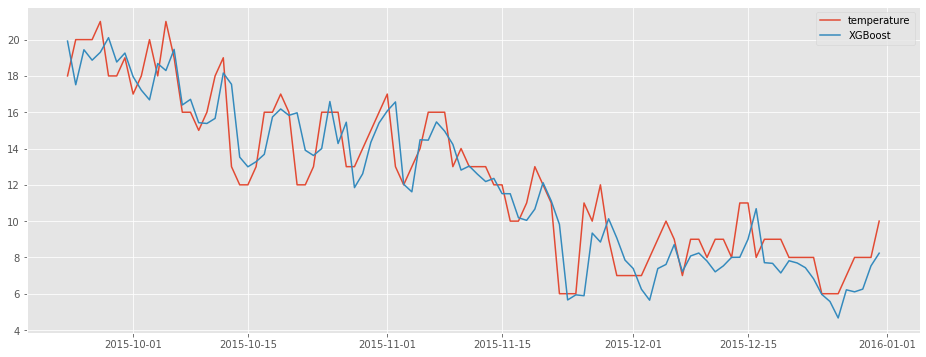

In [1209]:
plot_series({f'{TARGET}': y_true, 'XGBoost': y_hat}, -VIEW_PERIOD)

In [1210]:
# window size grid search
for param in [1,5,10,30,60]:
    X_train,Y_train = windowed_data(exog_data[:TEST_PERIOD], target_index=TARGET_INDEX, window_size=param)
    X_test, _ = windowed_data(exog_data[TEST_PERIOD-param:], target_index=TARGET_INDEX, window_size=param)
    model_ = XGBRegressor(objective='reg:squarederror', reg_lambda=10, n_estimators=100)
    model_.fit(X_train,Y_train)
    y_hat = model_.predict(X_test)
    print(param, '\t', MAE(y_true, y_hat))

1 	 1.4758127545657223
5 	 1.4174289651113015
10 	 1.414825929572049
30 	 1.4434916515872902
60 	 1.4390581335651276


### Feature Importance

In [ ]:
fi = model.feature_importances_
fi = np.reshape(fi, (WINDOW_SIZE,-1))
fi = pd.DataFrame(fi, columns=exog_cols)
# fi

In [1212]:
fi.apply(sum, axis=0)

temperature      0.739309
dewpoint         0.039921
humidity         0.051591
pressure         0.042905
visibility       0.022803
windspeed        0.047284
precipitation    0.003662
rain             0.015810
winddirection    0.036715
dtype: float64

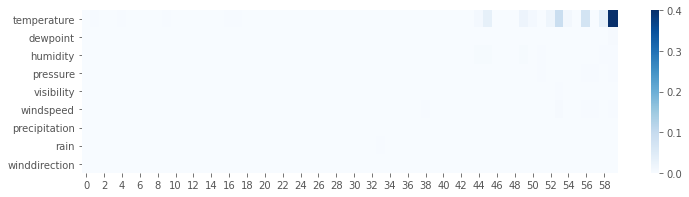

In [1222]:
plt.figure(figsize=(12,3))
sns.heatmap(fi.T, cmap='Blues')
plt.show()

Observations:
- previous day's temperature is the most influential feature by far (sanity check)
- strange pattern of -4,-7 days being more influential than -3, -6
- the model is not purely autoregressive: ~25% of tree splits along other variables

# Ensembles

In [1214]:
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772
2,temperature,uni,1,"SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074753
3,temperature,uni,1,"Incremental SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074502
4,temperature,multi,1,"Multivariate SARIMAX (1, 0, 1)(0, 1, 0, 365)",2.028708
5,temperature,uni,1,LSTM-32 Dense-16,1.505956
6,temperature,multi,1,Multivariate LSTM-512 Dense-16,1.419175
7,temperature,multi,1,XGBoost,1.431866


In [1215]:
residuals = np.zeros((len(y_true), len(y_hats)))

for i, y_hat in enumerate(y_hats):
    residuals[:,i] =  y_hat-y_true
    
res_corr = pd.DataFrame(columns=reports.forecast, data=residuals).corr()

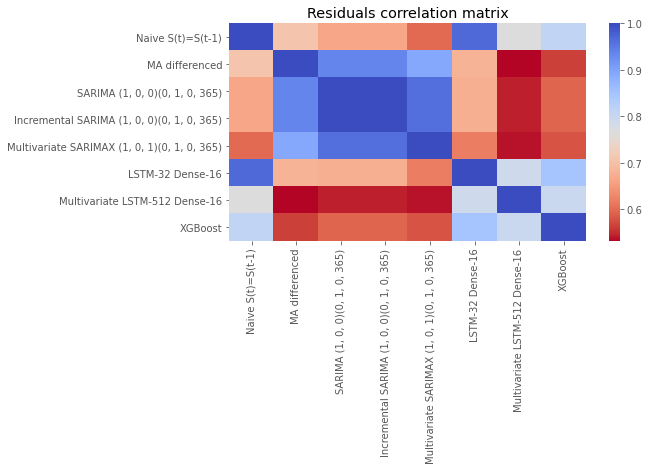

In [1216]:
plt.figure(figsize=(8,4))
sns.heatmap(res_corr, cmap='coolwarm_r')
plt.title('Residuals correlation matrix')
plt.xlabel('')
plt.ylabel('')
plt.show()

Try a simple 50/50 of the **2 best models**:

In [1217]:
y_hat = (y_hats[-1]+y_hats[-2])/2
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.4585876, 6.274405 , 6.8873696, 7.9070377, 8.179885 ],
      dtype=float32)

In [1218]:
reports.loc[len(reports)] = [TARGET, 'multi', HORIZON, 'Ensemble multivariate XGBoost+RNN', MAE(y_true, y_hat)]
reports

,target,var,horizon,forecast,MAE
0,temperature,uni,1,Naive S(t)=S(t-1),1.488584
1,temperature,uni,1,MA differenced,2.149772
2,temperature,uni,1,"SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074753
3,temperature,uni,1,"Incremental SARIMA (1, 0, 0)(0, 1, 0, 365)",2.074502
4,temperature,multi,1,"Multivariate SARIMAX (1, 0, 1)(0, 1, 0, 365)",2.028708
5,temperature,uni,1,LSTM-32 Dense-16,1.505956
6,temperature,multi,1,Multivariate LSTM-512 Dense-16,1.419175
7,temperature,multi,1,XGBoost,1.431866
8,temperature,multi,1,Ensemble multivariate XGBoost+RNN,1.327881


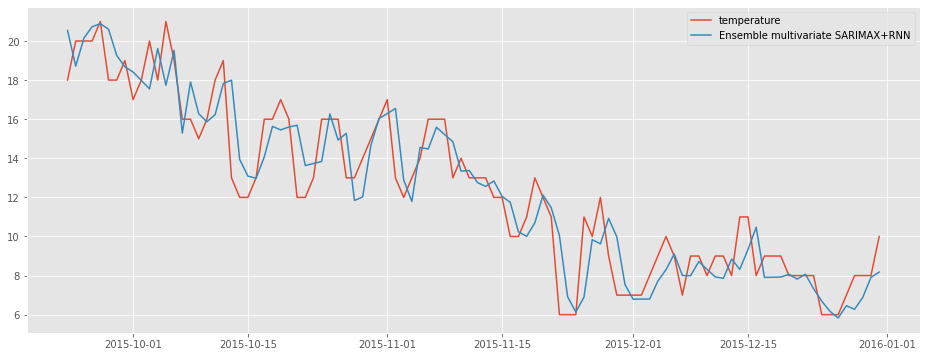

In [1219]:
plot_series({f'{TARGET}': y_true, 'Ensemble multivariate SARIMAX+RNN': y_hat}, -VIEW_PERIOD)

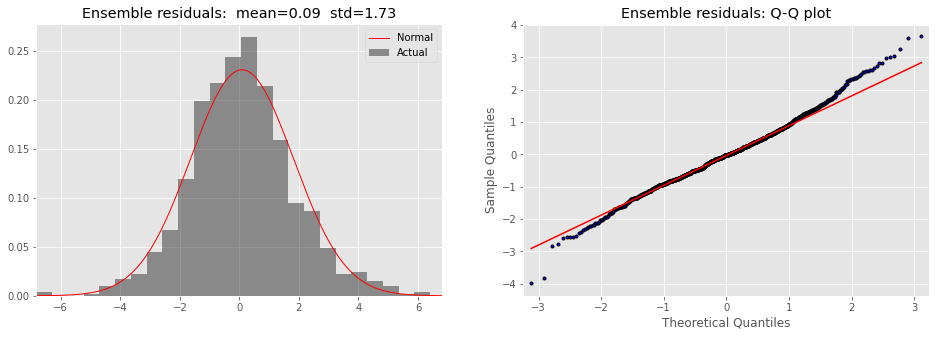

In [1220]:
plot_normal_qq(y_hat-y_true, 'Ensemble residuals')

Fat tails in residuals. Large prediction errors are more likely compared to the white noise.

# Compare Models

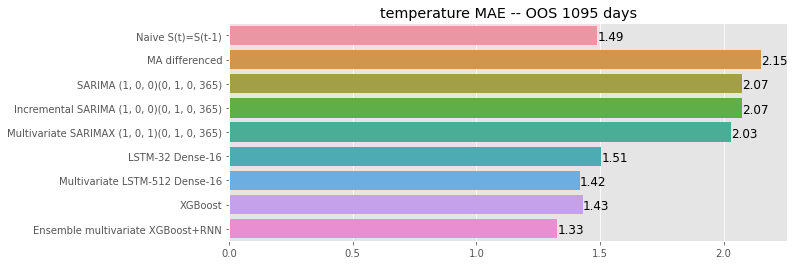

In [1221]:
plt.figure(figsize=(10,4))
sns.barplot(reports.MAE, reports.forecast, orient='h')
for i, mae in enumerate(reports.MAE): plt.text(mae, i+0.2, f'{mae:.2f}', fontsize=12)
plt.title(f'{TARGET} MAE -- OOS {-TEST_PERIOD} days')
plt.xlabel(''); plt.ylabel(''); plt.show()